# Helpful score prediction

In [34]:
% matplotlib inline

import pickle
import numpy as np

import matplotlib.pyplot as plt
from operator import itemgetter

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

## Load video games review dataframe

In [13]:
with open('pickle/video_games.pkl', 'rb') as input:
    video_games = pickle.load(input)

In [14]:
# Get only the reviews with a helpful rate
video_games = video_games[video_games.helpfulRate >= 0]

# Create a columns that will be use as a label for our binary classification
video_games['helpfulOrNot'] = video_games['helpfulRate'].apply(lambda x: 'helpful' if x > 0.5 else 'notHelpful')

In [15]:
video_games.head()

overall  \
asin       reviewerID                
0700099867 A2HD75EMZR8QLN        1   
           A1DLMTOTHQ4AST        3   
           A361M14PU2GUEG        4   
           AN3YYDZAS3O1Y         5   
           AQTC623NCESZW         1   

                                                                  reviewText  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Installing the game was a struggle (because of...   
           A1DLMTOTHQ4AST  I got this version instead of the PS3 version,...   
           A361M14PU2GUEG  I had Dirt 2 on Xbox 360 and it was an okay ga...   
           AN3YYDZAS3O1Y   Loved playing Dirt 2 and I thought the graphic...   
           AQTC623NCESZW   I can't tell you what a piece of dog**** this ...   

                                           reviewerName  \
asin       reviewerID                                     
0700099867 A2HD75EMZR8QLN                           123   
           A1DLMTOTHQ4AST                      ampgreen   
           A361M14PU2GUEG  Angry Ryan "Ryan A. Forrest"   
           AN3YYDZAS3O1Y                            Bob   
           AQTC623NCESZW                  Chesty Puller   

                                                                   summary  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN         Pay to unlock content? I don't think so.   
           A1DLMTOTHQ4AST  awesome game, if it did not crash frequently !!   
           A361M14PU2GUEG                                           DIRT 3   
           AN3YYDZAS3O1Y       A step up from Dirt 2 and that is terrific!   
           AQTC623NCESZW             Crash 3 is correct name AKA Microsoft   

                                date  helpfulRate  helpfulCount  rank  \
asin       reviewerID                                                   
0700099867 A2HD75EMZR8QLN 2012-07-09     0.666667            12  6629   
           A1DLMTOTHQ4AST 2011-09-14     0.700000            10  6629   
           A361M14PU2GUEG 2011-06-14     1.000000             2  6629   
           AN3YYDZAS3O1Y  2011-08-14     0.846154            13  6629   
           AQTC623NCESZW  2012-11-24     0.250000             4  6629   

                                                                 description  \
asin       reviewerID                                                          
0700099867 A2HD75EMZR8QLN  Dirt 3 is a popular rally racing game for Play...   
           A1DLMTOTHQ4AST  Dirt 3 is a popular rally racing game for Play...   
           A361M14PU2GUEG  Dirt 3 is a popular rally racing game for Play...   
           AN3YYDZAS3O1Y   Dirt 3 is a popular rally racing game for Play...   
           AQTC623NCESZW   Dirt 3 is a popular rally racing game for Play...   

                            price title brand  reviewLength  summaryLength  \
asin       reviewerID                                                        
0700099867 A2HD75EMZR8QLN  246.63                       779             40   
           A1DLMTOTHQ4AST  246.63                      3489             47   
           A361M14PU2GUEG  246.63                       294              6   
           AN3YYDZAS3O1Y   246.63                       431             43   
           AQTC623NCESZW   246.63                       728             37   

                           reviewerNameLength helpfulOrNot  
asin       reviewerID                                       
0700099867 A2HD75EMZR8QLN                 3.0      helpful  
           A1DLMTOTHQ4AST                 8.0      helpful  
           A361M14PU2GUEG                28.0      helpful  
           AN3YYDZAS3O1Y                  3.0      helpful  
           AQTC623NCESZW                 13.0   notHelpful

## Pipeline classication

### Text preprocessing

In [16]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [17]:
print('Original review text:')
print(video_games.iloc[19].reviewText)
print('Preprocessed text:')
print(NLTKPreprocessor().transform([video_games.iloc[19].reviewText])[0])

Original review text:
We bought this item for our Wii. It does not work at all for it. :-( So that was a disapointment. We did decide to keep it though because it works wonderfully on our x-box 360.
Preprocessed text:
['buy', 'item', 'wii', 'work', 'disapointment', 'decide', 'keep', 'though', 'work', 'wonderfully', 'x', 'box', '360']


### Create pipeline

In [18]:
from sklearn.svm import SVC

class MultipleItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        if not isinstance(data_dict[:, self.keys][0], str):
            return np.array(list(data_dict[:, self.keys])).reshape(len(data_dict), 1)
        return data_dict[:, self.keys]
    
class TextLength(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text)} for text in posts]

def identity(x): 
    return x

def create_pipeline(classifier=SGDClassifier):
    if isinstance(classifier, type):
        classifier = classifier()

    model = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('summary', Pipeline([
                    ('selector', MultipleItemSelector(keys=0)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorizer', TfidfVectorizer(
                        tokenizer=identity, preprocessor=None, lowercase=False
                    )),
#                     ('best', TruncatedSVD(n_components=50)), # LSA
                ])),
                ('reviewText', Pipeline([
                    ('selector', MultipleItemSelector(keys=1)),
                    ('preprocessor', NLTKPreprocessor()),
                    ('vectorizer', TfidfVectorizer(
                        tokenizer=identity, preprocessor=None, lowercase=False
                    )),
#                     ('best', TruncatedSVD(n_components=100)), # LSA
                ])),
#                 ('reviewText_length', Pipeline([
#                     ('selector', MultipleItemSelector(keys=1)),
#                     ('stats', TextLength()),  # returns a list of dicts
#                     ('vect', DictVectorizer()),  # list of dicts -> feature matrix
#                 ])),
                ('helpfulCount', Pipeline([
                    ('selector', MultipleItemSelector(keys=2)),
                ])),
                 ('reviewText_length', Pipeline([
                    ('selector', MultipleItemSelector(keys=3)),
                ])),
                
            ],
            transformer_weights={
                'summary': 0.5,
                'reviewText': 0.5,
                'helpfulCount': 1.0,
                'reviewText_length': 1.0,
            },
        )),

        ('classifier', classifier),
    ])
        

    return model

### Test on playstation reviews

In [19]:
ps_reviews = video_games.loc['B00BGA9WK2']
len(ps_reviews)

760

In [20]:
y = ps_reviews.helpfulOrNot.values
# y = ps_reviews.overall.apply(lambda x: str(x)).values
X = ps_reviews.summary.values
X = X.reshape(len(X), 1)
X = np.append(X, np.array(ps_reviews.reviewText.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.helpfulCount.values).reshape(len(X), 1), 1)
X = np.append(X, np.array(ps_reviews.reviewLength.values).reshape(len(X), 1), 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model = create_pipeline(classifier=SVC(kernel='linear'))
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred, target_names=label_encoder.classes_))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

             precision    recall  f1-score   support

    helpful       0.90      0.61      0.73       318
 notHelpful       0.69      0.93      0.79       290

avg / total       0.80      0.76      0.76       608

             precision    recall  f1-score   support

    helpful       0.62      0.27      0.37        97
 notHelpful       0.35      0.71      0.47        55

avg / total       0.52      0.43      0.41       152



### Evaluate model

In [32]:
train_accs = []
test_accs = []

for i in range(int(len(X_train) / 10), len(X_train), int(len(X_train) / 10)):
    model = create_pipeline(classifier=SVC(kernel='linear'))
    model.fit(X_train[:i], y_train[:i])
    
    y_pred = model.predict(X_train[:i])
    train_acc = accuracy_score(y_train[:i], y_pred)
    train_accs.append(train_acc)
    
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_accs.append(test_acc)
    print(test_acc)

0.638157894737
0.572368421053
0.421052631579
0.394736842105
0.453947368421
0.460526315789
0.427631578947
0.447368421053
0.453947368421
0.447368421053


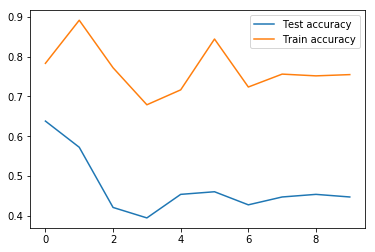

In [42]:
plt.plot(test_accs, label="Test accuracy")
plt.plot(train_accs, label="Train accuracy")
plt.legend();